In [1]:
from normalorder.sense.model import Model
import sympy
import numpy as np
np.random.seed(seed=0)
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Setup
We create an instance of the Model class and set the order up to which we wish to carry out a Taylor series expansion of the potential.

In [2]:
order = 4

model = Model()
model.set_order(order)

Next we use sympy to define the potential. First we define the parameter symbols which are used to write down the potential along with phi_sym, which is the phase difference over the inductive element in the resonator. 

Then we place the parameter symbols into a dictionary where the keys are the symbol names, before constructing the potential as an expression. This expression is fed to the model along with the dictionary which names the symbols.

The potenial expression is stored as an attribute of the model at model.potential_expr.

In [3]:
phi_sym, phi_ext_sym, nu_sym, n_sym, f_J_sym = sympy.symbols('phi phi_ext nu n f_J')
potential_param_symbols = {'phi_ext': phi_ext_sym,
                           'nu': nu_sym,
                           'n': n_sym,
                           'f_J': f_J_sym}
potential_expr = -nu_sym * sympy.cos(phi_sym) - n_sym * sympy.cos((phi_ext_sym - phi_sym) / n_sym)
model.set_potential(potential_expr, potential_param_symbols)

model.potential_expr

-n*cos((-phi + phi_ext)/n) - nu*cos(phi)

Now we specify the numerical values of these parameters by defining them in \hat{a} dictionary where the keys \hat{a}re the names of the parameters.

In [4]:
n = 3
phi_ext = 2 * np.pi * np.random.rand()
nu = 0.3
f_J = 7500.0
potential_params = {'phi_ext': phi_ext,
                    'nu': nu,
                    'n': n,
                    'f_J': f_J}

model.set_potential_params(potential_params)

Next we define the parameters of the resonator modes. The parameters of each mode will be defined in separate dictionaries which are then collected together as items of an overall dictionary whose keys are the mode names i.e. 'a' and 'b' in this case.

Each of the subdictionaries should contain f, I_ratio and kappa:

f : float
The frequency of the mode in GHz.

I_ratio : float
Ratio of the rms current of the mode at the location of the inductive element to the critical current I_c = 2 * e * f_J.


kappa : float
The relaxation rate of the mode in GHz. The time constant of relaxation is given by 1/(2 * pi * kappa).

In [5]:
resonator_params_a = {'f': 1.0,
                      'I_ratio': 0.001,
                      'kappa': 0.001}

resonator_params_b = {'f': 2.0,
                      'I_ratio': 0.001,
                      'kappa': 0.002}

resonator_params = {'a': resonator_params_a,
                    'b': resonator_params_b}

model.set_resonator_params(resonator_params)

Next we set the parameters of the drive. The drive will always be applied to the the first mode. In thise case mode 'a'.

In [6]:
f_d = 1.0
epsilon = 0.001
model.set_drive_params(f_d, epsilon)

model.mode_names

['a', 'b']

# Generating the equations of motion

Now we can generate the Hamiltonian and Lindblad operators, which will be stored in the attributes model.hamiltonian and model.lindblad_ops.

In [7]:
model.generate_hamiltonian()
model.generate_lindblad_ops()

These are used to generate the operators $O_a$ and $O_b$ on the right hand sides of the equations of motion:
$$\partial_t a = \text{Tr} \Bigg[ \Bigg( i [H, \hat{a}] + \sum_m \bigg( L^\dagger_m \hat{a} L_m - \frac{1}{2} \hat{a} L_m^\dagger L_m - \frac{1}{2} L_m^\dagger L_m \hat{a} \bigg) \Bigg) \rho \Bigg] \\ = \text{Tr} \Big[ O_a \rho \Big]$$

$$\partial_t b = \text{Tr} \Bigg[ \Bigg( i [H, \hat{b}] + \sum_m \bigg( L^\dagger_m \hat{b} L_m - \frac{1}{2} \hat{b} L_m^\dagger L_m - \frac{1}{2} L_m^\dagger L_m \hat{b} \bigg) \Bigg) \rho \Bigg] \\ = \text{Tr} \Big[ O_b \rho \Big]$$

$O_a$ and $O_b$ are stored at model.eom_ops.

In [8]:
model.generate_eom_ops()

Next we make the classical approximation, i.e. $\rho = \vert a \rangle \langle a \vert \otimes \vert b \rangle \langle b \vert$, and generate the right hand sides of the above equations of motion in symbolic form. The expressions describing these equations of motion are stored at model.eom_exprs.

In [9]:
model.generate_eom_exprs()

## Static external field
Finally we are ready to generate the equations of motion in a form which can be numerically integrated, which will be stored at model.eom.

In [10]:
model.generate_eom()

def ode_wrapper(t, y):
    return model.eom(y)

t_span = [0, 2000]
t_eval = np.linspace(*t_span, 10001)
y_0 = np.array([0.0, 0.0], dtype=complex)
tol = 1e-7
sol = solve_ivp(ode_wrapper, t_span, y_0, t_eval=t_eval, rtol=tol, atol=tol)
sol_frame = pd.DataFrame(sol.y.T, index=sol.t, columns=model.mode_names)

Text(0, 0.5, '$\\beta$')

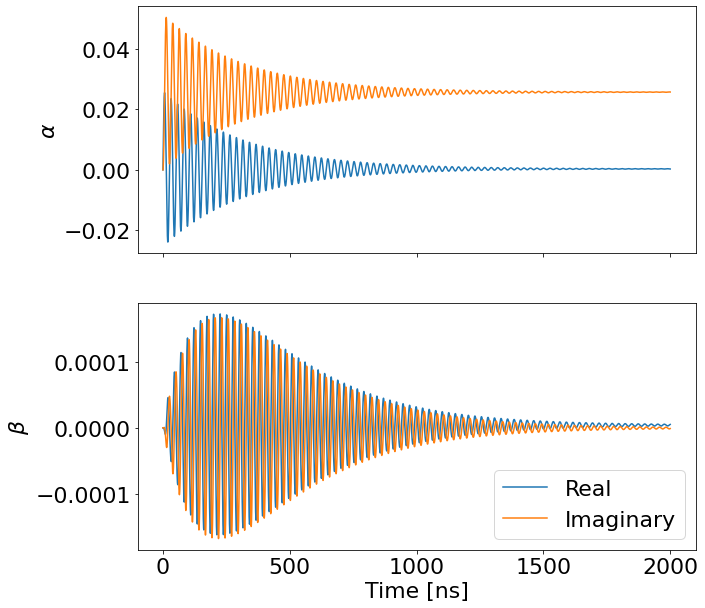

In [11]:
matplotlib.rcParams.update({'font.size': 22})

fig, axes = plt.subplots(2,1,figsize=(10,10),sharex=True)

sol_frame['a'].map(lambda x: x.real).plot(ax=axes[0])
sol_frame['a'].map(lambda x: x.imag).plot(ax=axes[0])

sol_frame['b'].map(lambda x: x.real).plot(ax=axes[1])
sol_frame['b'].map(lambda x: x.imag).plot(ax=axes[1])

legend = axes[1].legend(['Real', 'Imaginary'], loc=4)

axes[1].set_xlabel('Time [ns]')
axes[0].set_ylabel(r'$\alpha$')
axes[1].set_ylabel(r'$\beta$')

## Variable external field
We can also generate equations of motion in which the parameters of the potential can be varied. In the example below we allow the external magnetic field, phi_ext, to be varied.

In [12]:
model.generate_eom(potential_variables=['phi_ext'])

def ode_wrapper(t, y):
    f_phi_ext = 0.01
    delta_phi_ext = 0.1*np.cos(2*np.pi*f_phi_ext*t)
    return model.eom(y, delta_phi_ext)

t_span = [0, 2000]
t_eval = np.linspace(*t_span, 10001)
y_0 = np.array([0.0, 0.0], dtype=complex)
tol = 1e-7
sol = solve_ivp(ode_wrapper, t_span, y_0, t_eval=t_eval, rtol=tol, atol=tol)
sol_frame = pd.DataFrame(sol.y.T, index=sol.t, columns=model.mode_names)

Text(0, 0.5, '$\\beta$')

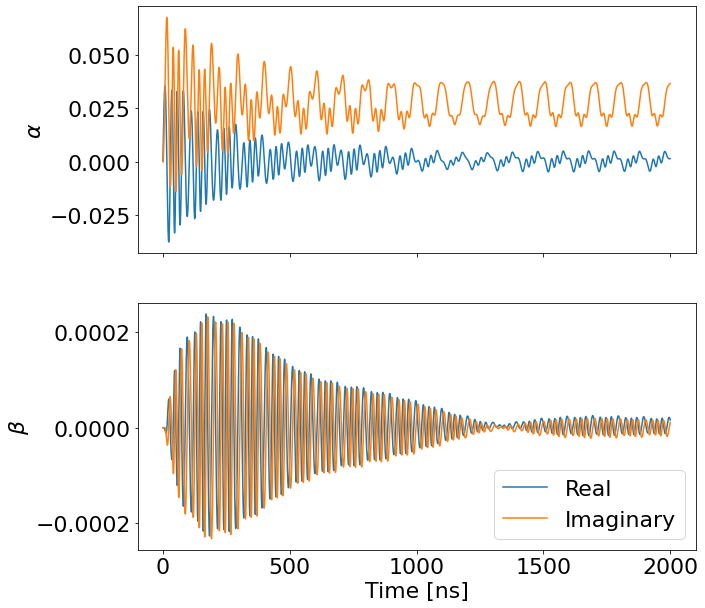

In [13]:
matplotlib.rcParams.update({'font.size': 22})

fig, axes = plt.subplots(2,1,figsize=(10,10),sharex=True)

sol_frame['a'].map(lambda x: x.real).plot(ax=axes[0])
sol_frame['a'].map(lambda x: x.imag).plot(ax=axes[0])

sol_frame['b'].map(lambda x: x.real).plot(ax=axes[1])
sol_frame['b'].map(lambda x: x.imag).plot(ax=axes[1])

legend = axes[1].legend(['Real', 'Imaginary'], loc=4)

axes[1].set_xlabel('Time [ns]')
axes[0].set_ylabel(r'$\alpha$')
axes[1].set_ylabel(r'$\beta$')

# Examining coefficients
We can generate the g coefficients symbolically as follows:

In [14]:
m = 3
model.generate_g_expr(m)

-0.25*c_1*c_4/c_2**4 + 0.5625*c_1*c_3**2/c_2**5 - 0.25*c_3/c_2**3

We can numerically calculate the values of c and g coefficients. First we choose the value of the phase, phi, around which to carry out the Taylor expansion of the potential.

In [15]:
phi = 2.5
m = 3
print(model.c_func(m,phi))
print(model.g_func(m,phi))

-0.02416691847410038
-288.4314001239535
